## Data Augmentation

In [1]:
import random
import numpy as np
from connectomics.config import get_cfg_defaults
from connectomics.data.dataset.build import _get_input
from connectomics.data.augmentation import *

In [2]:
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib.colors import Normalize
norm = Normalize(vmin=0, vmax=1, clip=False)

def show(image, cmap='gray', title='Test Title', use_norm=False):
    num_imgs = image.shape[0]
    fig = plt.figure(figsize=(20., 3.))
    fig.suptitle(title)
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(1, 6),  # creates 2x2 grid of axes
                     axes_pad=0.1,  # pad between axes in inch.
                     )
    image_list = np.split(image, num_imgs, 0)
    for ax, im in zip(grid, [np.squeeze(x) for x in image_list]):
        # Iterating over the grid returns the Axes.
        ax.imshow(im, cmap=cmap, norm=norm if use_norm else None,
                  interpolation='none')
        ax.axis('off')

    plt.show()

In [3]:
# Load configs and dataset
cfg_filename = '../configs/SNEMI/SNEMI-Base.yaml'
cfg = get_cfg_defaults()
cfg.merge_from_file(cfg_filename)
cfg.DATASET.INPUT_PATH = '../datasets/SNEMI3D/'
cfg.DATASET.PAD_SIZE = [0, 0, 0]
cfg.MODEL.INPUT_SIZE = [6, 256, 256]
volume, label, _ = _get_input(cfg, mode='train')

additional_targets = {'label': 'mask', 
                      'valid_mask': 'mask'}

None 1 ['train_image.h5']
volume shape (original): (100, 1024, 1024)
volume shape (after scaling and padding): (100, 1024, 1024)
label shape (after scaling and padding): (100, 1024, 1024)


In [4]:
def test_augmentation(volume, label, tranforms, additional_targets,
                      smooth=False, show_uncropped=False):
    
    augmentor = Compose(tranforms,
                        input_size = (6, 256, 256),
                        keep_uncropped = True,
                        smooth = smooth, 
                        keep_non_smoothed = True,
                        additional_targets = additional_targets)
    
    zz, yy, xx = augmentor.sample_size
    temp_image = volume[0][:zz,:yy,:xx] / 255.0
    temp_label = label[0][:zz,:yy,:xx]
    temp_valid = random_valid_mask(temp_label)
    
    show(temp_image, title='Original Images [%dx%d]' 
         % (temp_image.shape[1], temp_image.shape[2]))
    
    sample = {'image': temp_image, 
              'label': temp_label,
              'valid_mask': temp_valid}
    augmented = augmentor(sample)
    
    if show_uncropped:
        for key in ['uncropped_image', 'uncropped_label', 'uncropped_valid_mask']:
            cmap = 'tab20c' if key == 'uncropped_label' else 'gray'
            use_norm = True if key == 'uncropped_valid_mask' else False
            show(augmented[key], cmap=cmap, title='%s [%dx%d]' % (key, 
                 augmented[key].shape[1], augmented[key].shape[2]), use_norm=use_norm)
        
    for key in ['image', 'label', 'valid_mask']:
        cmap = 'tab20c' if key == 'label' else 'gray'
        use_norm = True if key == 'valid_mask' else False
        show(augmented[key], title='%s [%dx%d]' % (key, 
             augmented[key].shape[1], augmented[key].shape[2]), use_norm=use_norm)
    
def random_valid_mask(label, k=3):
    valid_mask = np.ones_like(label)
    num_slices, h, w = label.shape
    indices = random.sample(list(range(num_slices)), k)
    for i in indices:
        y_low, y_high = random.randint(0, h//2), random.randint(h//2, h-1)
        x_low, x_high = random.randint(0, w//2), random.randint(w//2, w-1)
        valid_mask[i, y_low:y_high, x_low:x_high] = 0
    return valid_mask

### Mis-alignment augmentation by rotation

Sample size required for the augmentor: [  6 284 284]


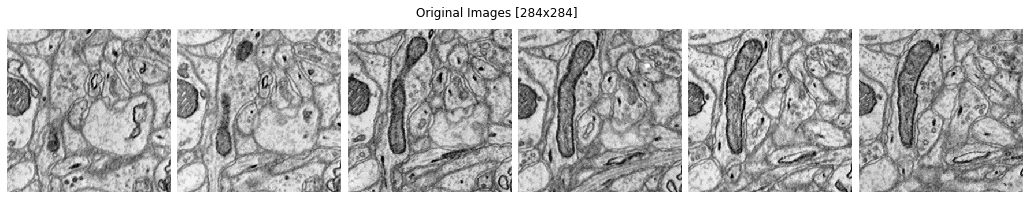

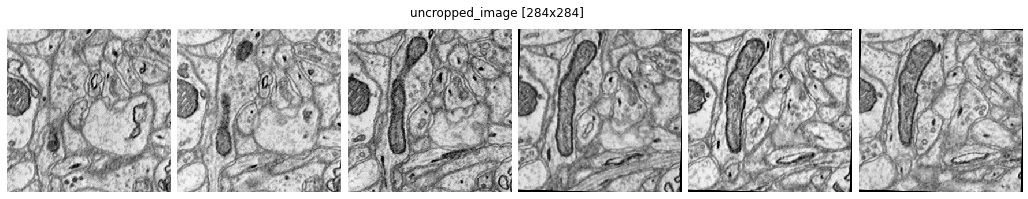

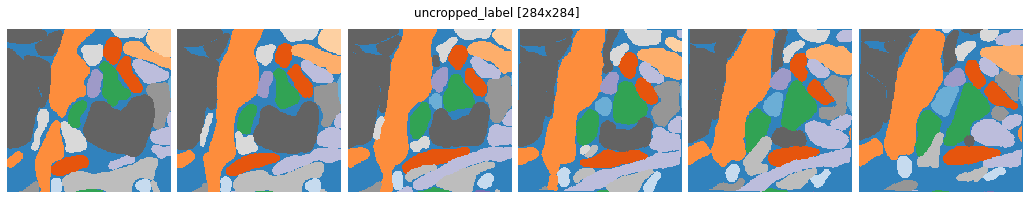

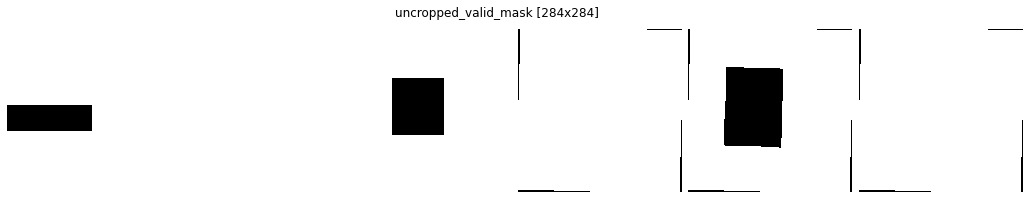

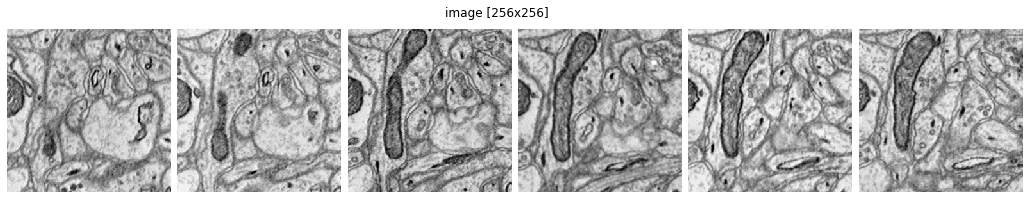

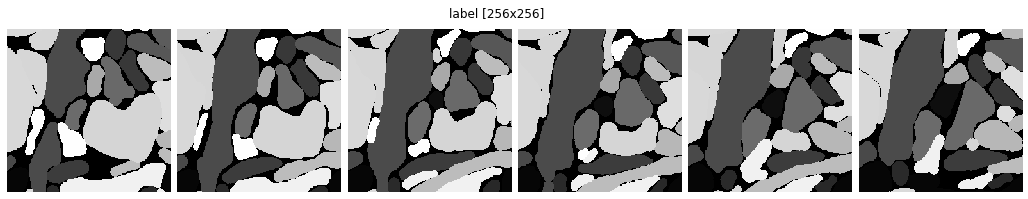

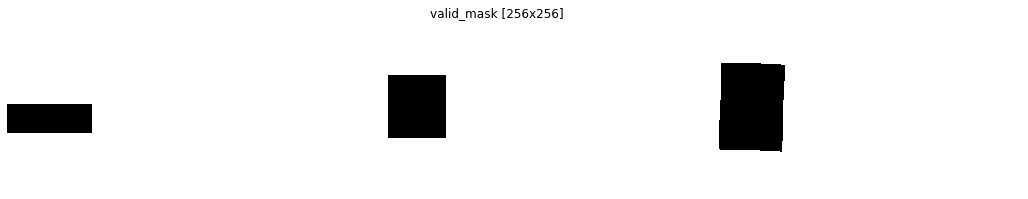

In [5]:
transforms = [MisAlignment(displacement=28, rotate_ratio=1.0, p=1.0, 
                           additional_targets=additional_targets)]
test_augmentation(volume, label, transforms, additional_targets, show_uncropped=True)

### CutBlur augmentation

Sample size required for the augmentor: [  6 256 256]


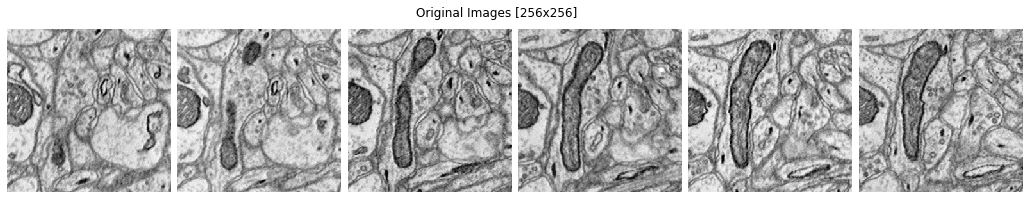

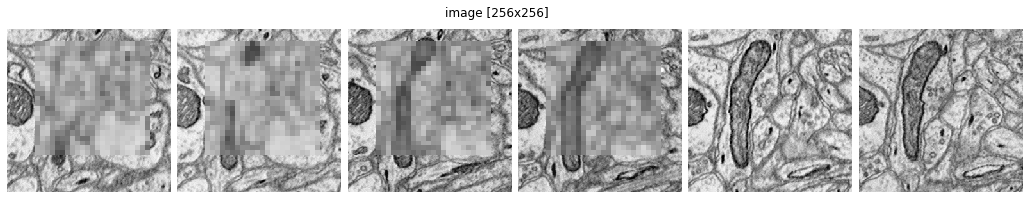

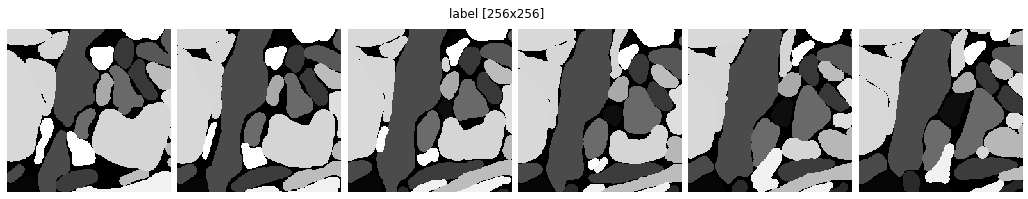

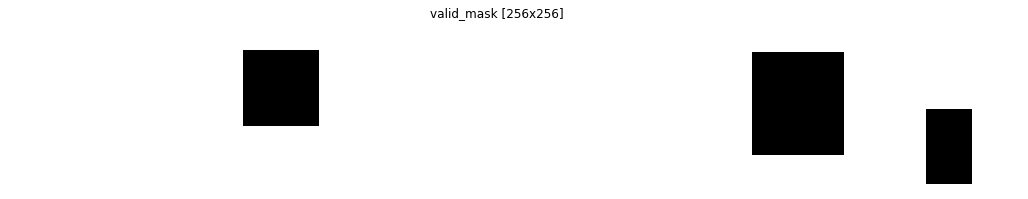

In [6]:
transforms = [CutBlur(length_ratio=0.7, down_ratio_min=6.0,
                      p=1.0, additional_targets=additional_targets)]
test_augmentation(volume, label, transforms, additional_targets, show_uncropped=False)

### Rescale Augmentation

Sample size required for the augmentor: [  6 320 320]


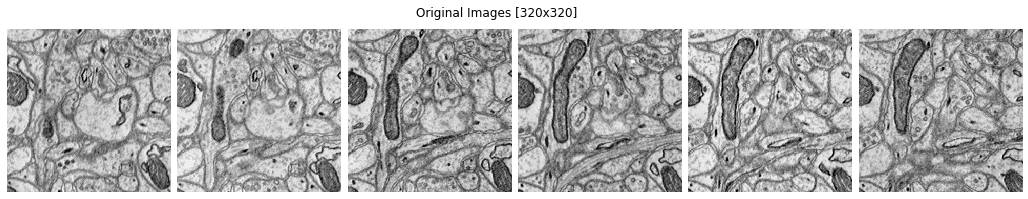

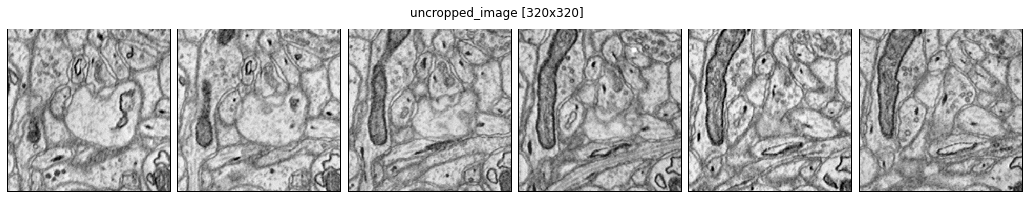

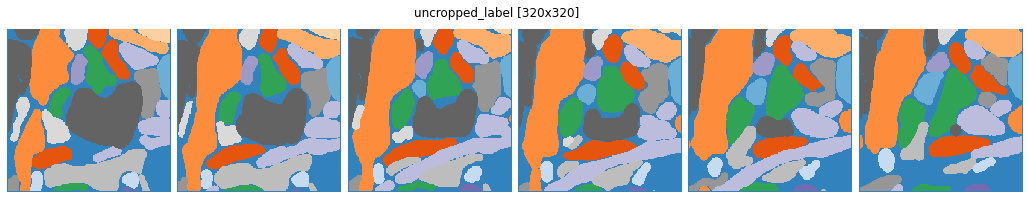

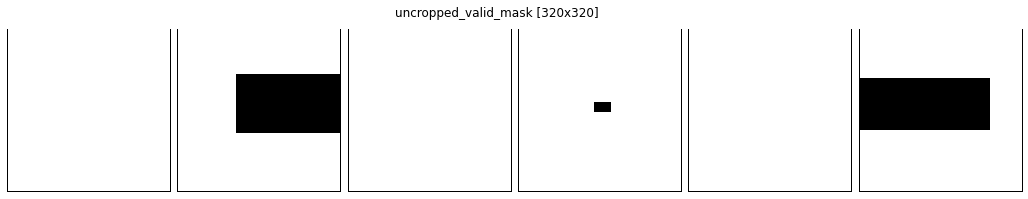

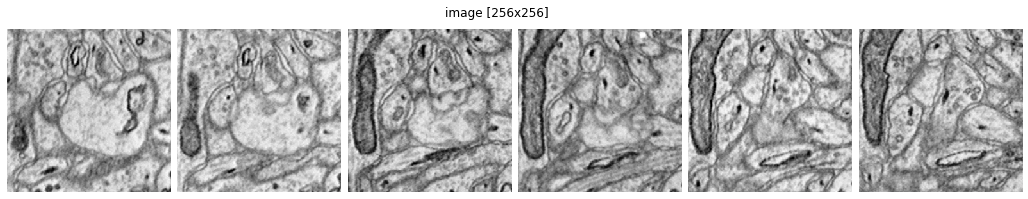

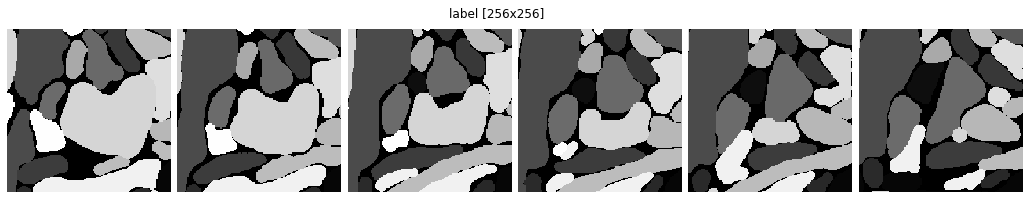

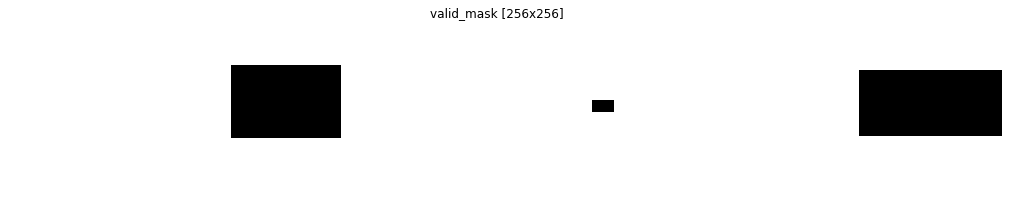

In [7]:
transforms = [Rescale(p=1.0, additional_targets=additional_targets)]
test_augmentation(volume, label, transforms, additional_targets, show_uncropped=True)

### MissingParts Augmentation

Sample size required for the augmentor: [  6 256 256]


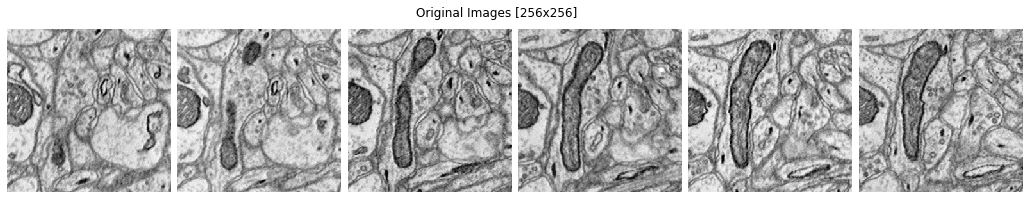

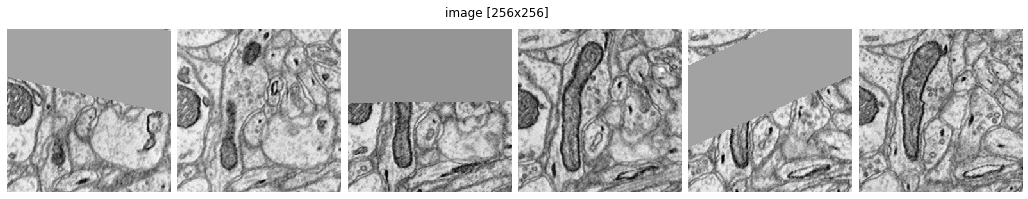

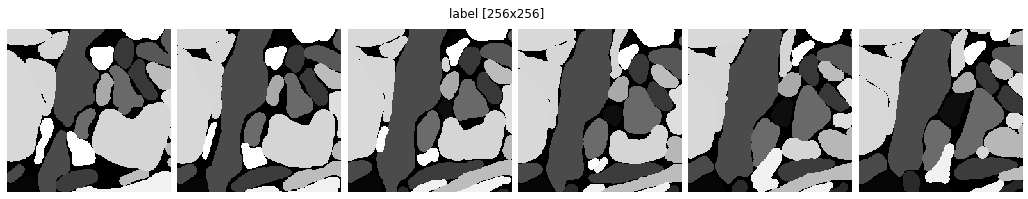

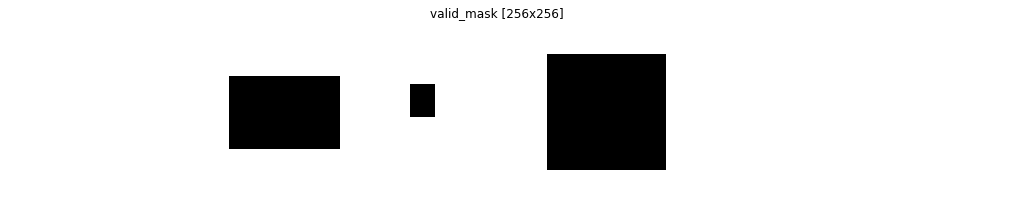

In [8]:
transforms = [MissingParts(p=1.0, additional_targets=additional_targets)]
test_augmentation(volume, label, transforms, additional_targets, show_uncropped=False)

### Skip specified augmentations for additional targets

Sample size required for the augmentor: [  6 284 284]


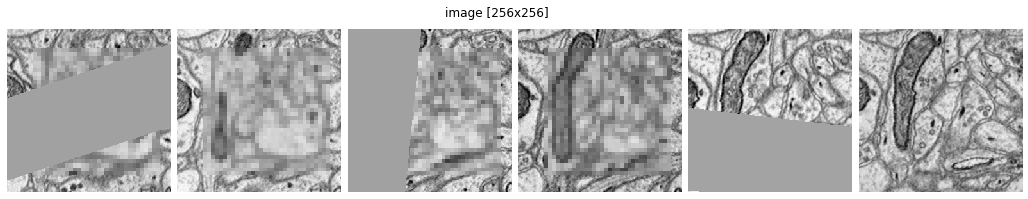

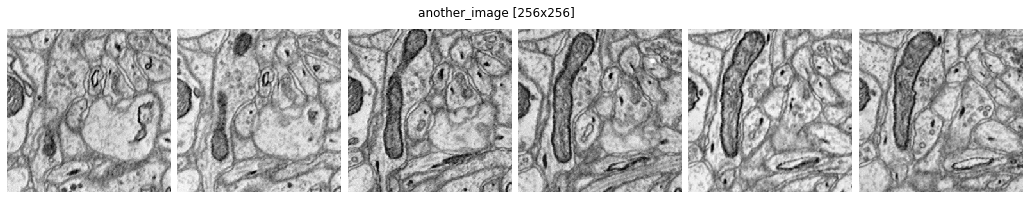

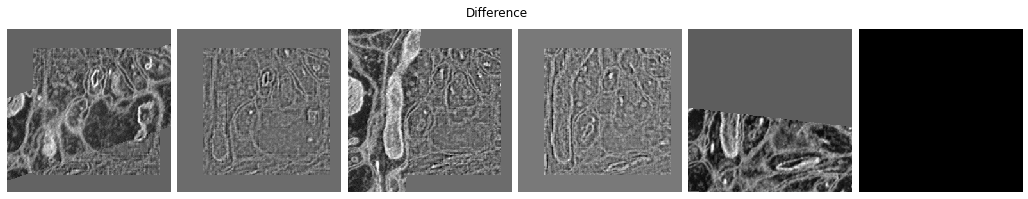

In [9]:
additional_targets = {'another_image': 'img'}
tranforms = [
    MissingParts(p=1.0, additional_targets=additional_targets, skip_targets=['another_image']),
    CutBlur(length_ratio=0.7, down_ratio_min=6.0, p=1.0, 
            additional_targets=additional_targets, skip_targets=['another_image']),
    MisAlignment(displacement=28, rotate_ratio=1.0, p=1.0, additional_targets=additional_targets)
]

augmentor = Compose(tranforms,
                    input_size = (6, 256, 256),
                    additional_targets = additional_targets)
    
zz, yy, xx = augmentor.sample_size
image = volume[0][:zz,:yy,:xx] / 255.0
    
sample = {'image': image, 
          'another_image': image}
augmented = augmentor(sample)
out_image, out_another = augmented['image'], augmented['another_image']
    
for key in ['image', 'another_image']:     
    show(augmented[key], title='%s [%dx%d]' % (key, 
         augmented[key].shape[1], augmented[key].shape[2]))
diff = augmented['image'] - augmented['another_image']
show(diff, title="Difference")